### Predictions

#### 4 beeps

In [1]:
import matplotlib.pyplot as plt
import itertools


def plot_neural_input(res, position=15):
    plt.plot(res.e_.auditory_total_input[:, position], label="Auditory")
    plt.plot(res.e_.visual_total_input[:, position], label="Visual")
    plt.plot(res.e_.multi_total_input[:, position], label="Multisensory")
    plt.ylabel("Neural input", size=14)
    plt.xlabel("Time", size=14)
    plt.legend()
    plt.show()


def plot_res_per_soa(result_list, position=15):
    fig, axs = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=True)
    idx = -1
    for res in result_list:
        idx += 1
        row, col = idx // 5, idx % 5
        sub_plot = res.plot.linet(position=15, ax=axs[row, col])
        sub_plot.get_legend().remove()
        sub_plot.set_title("SOA " + str(int(res.run_params.soa)) + " ms")

    handles, labels = sub_plot.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", borderaxespad=0.1)
    plt.subplots_adjust(right=0.935)
    plt.show()


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size

In [30]:
from skneuromsi.neural import Paredes2022
from joblib import Parallel, delayed
import numpy as np
from findpeaks import findpeaks
from skneuromsi.utils import storages
import os
from scipy.stats import uniform


def myjob_explore_beeps(
    soa,
    beeps_range,
    l_ex,
    fb_weight,
    cm_weight,
    ff_weight,
    a_tau,
    v_tau,
    m_tau,
    ff_pruning_threshold,
    cm_pruning_threshold,
    storage,
    storage_idx,
):
    visual_peak_count = []
    multi_peak_count = []

    model = Paredes2022(
        time_range=(0, 750),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    for n_beeps in beeps_range:
        res = model.run(
            soa=soa,
            auditory_stim_n=n_beeps,
            auditory_intensity=2.425,  # 2.425
            visual_intensity=1.375,  # 1.375
            visual_stim_n=1,
            auditory_duration=7,
            visual_duration=12,
            auditory_onset=10,
            visual_onset=34,
            cross_modal_weight=cm_weight,
            feedback_weight=fb_weight,
            feedforward_weight=ff_weight,
            lateral_excitation=l_ex,
            feedforward_pruning_threshold=ff_pruning_threshold,
            cross_modal_pruning_threshold=cm_pruning_threshold,
            noise=False,
            temporal_noise=True,
            temporal_noise_scale=5,
        )

        fp = findpeaks(method="topology", verbose=0, limit=0.40)
        fp_results = fp.fit(
            res.get_modes("visual").query("positions==15").visual.values
        )
        visual_peaks_df = fp_results["df"].query("peak==True & valley==False")

        multi_fp_results = fp.fit(
            res.get_modes("multi").query("positions==15").multi.values
        )
        multi_peaks_df = multi_fp_results["df"].query("peak==True & valley==False")

        visual_peak_count.append(visual_peaks_df["score"].size)
        multi_peak_count.append(multi_peaks_df["score"].size)

    storage[storage_idx] = visual_peak_count, multi_peak_count

In [31]:
soa = 48
n_sims = 30
beeps_range = np.arange(1, 5)

flashes_res = []
causes_res = []

sim_storage = storages.DirectoryStorage(size=n_sims, tag="beeps")
with Parallel(n_jobs=-3) as parallel:
    parallel(
        delayed(myjob_explore_beeps)(
            soa,
            beeps_range,
            1.6,
            2.423e-01,
            1.327e-02,
            2.461e00,
            6.712e00,
            2.356e01,
            1.175e02,
            0,
            0,
            sim_storage,
            sim,
        )
        for sim in range(n_sims)
    )

flashes_list = [i[0] for i in sim_storage]
flashes = np.array(flashes_list)
flashes_per_beep = flashes.mean(axis=0)

causes_list = [i[1] for i in sim_storage]
causes = np.array(causes_list)
causes_per_beep = causes.mean(axis=0)

sim_storage_hspq = storages.DirectoryStorage(size=n_sims, tag="beeps_hspq")
with Parallel(n_jobs=-3) as parallel:
    parallel(
        delayed(myjob_explore_beeps)(
            soa,
            beeps_range,
            1.632e00,
            2.423e-01,
            1.327e-02,
            2.461e00,
            6.712e00,
            2.356e01,
            1.175e02,
            0,
            0,
            sim_storage_hspq,
            sim,
        )
        for sim in range(n_sims)
    )

flashes_list_hspq = [i[0] for i in sim_storage_hspq]
flashes_hspq = np.array(flashes_list_hspq)
flashes_per_beep_hspq = flashes_hspq.mean(axis=0)

causes_list_hspq = [i[1] for i in sim_storage_hspq]
causes_hspq = np.array(causes_list_hspq)
causes_per_beep_hspq = causes_hspq.mean(axis=0)

sim_storage_hspq_alter = storages.DirectoryStorage(size=n_sims, tag="beeps_hspq_alter")
with Parallel(n_jobs=-3) as parallel:
    parallel(
        delayed(myjob_explore_beeps)(
            soa,
            beeps_range,
            1.6,
            2.423e-01,
            2.707e-02,
            2.461e00,
            6.712e00,
            2.356e01,
            1.175e02,
            0,
            0,
            sim_storage_hspq_alter,
            sim,
        )
        for sim in range(n_sims)
    )

flashes_list_hspq_alter = [i[0] for i in sim_storage_hspq_alter]
flashes_hspq_alter = np.array(flashes_list_hspq_alter)
flashes_per_beep_hspq_alter = flashes_hspq_alter.mean(axis=0)

causes_list_hspq_alter = [i[1] for i in sim_storage_hspq_alter]
causes_hspq_alter = np.array(causes_list_hspq_alter)
causes_per_beep_hspq_alter = causes_hspq_alter.mean(axis=0)

#### Plot

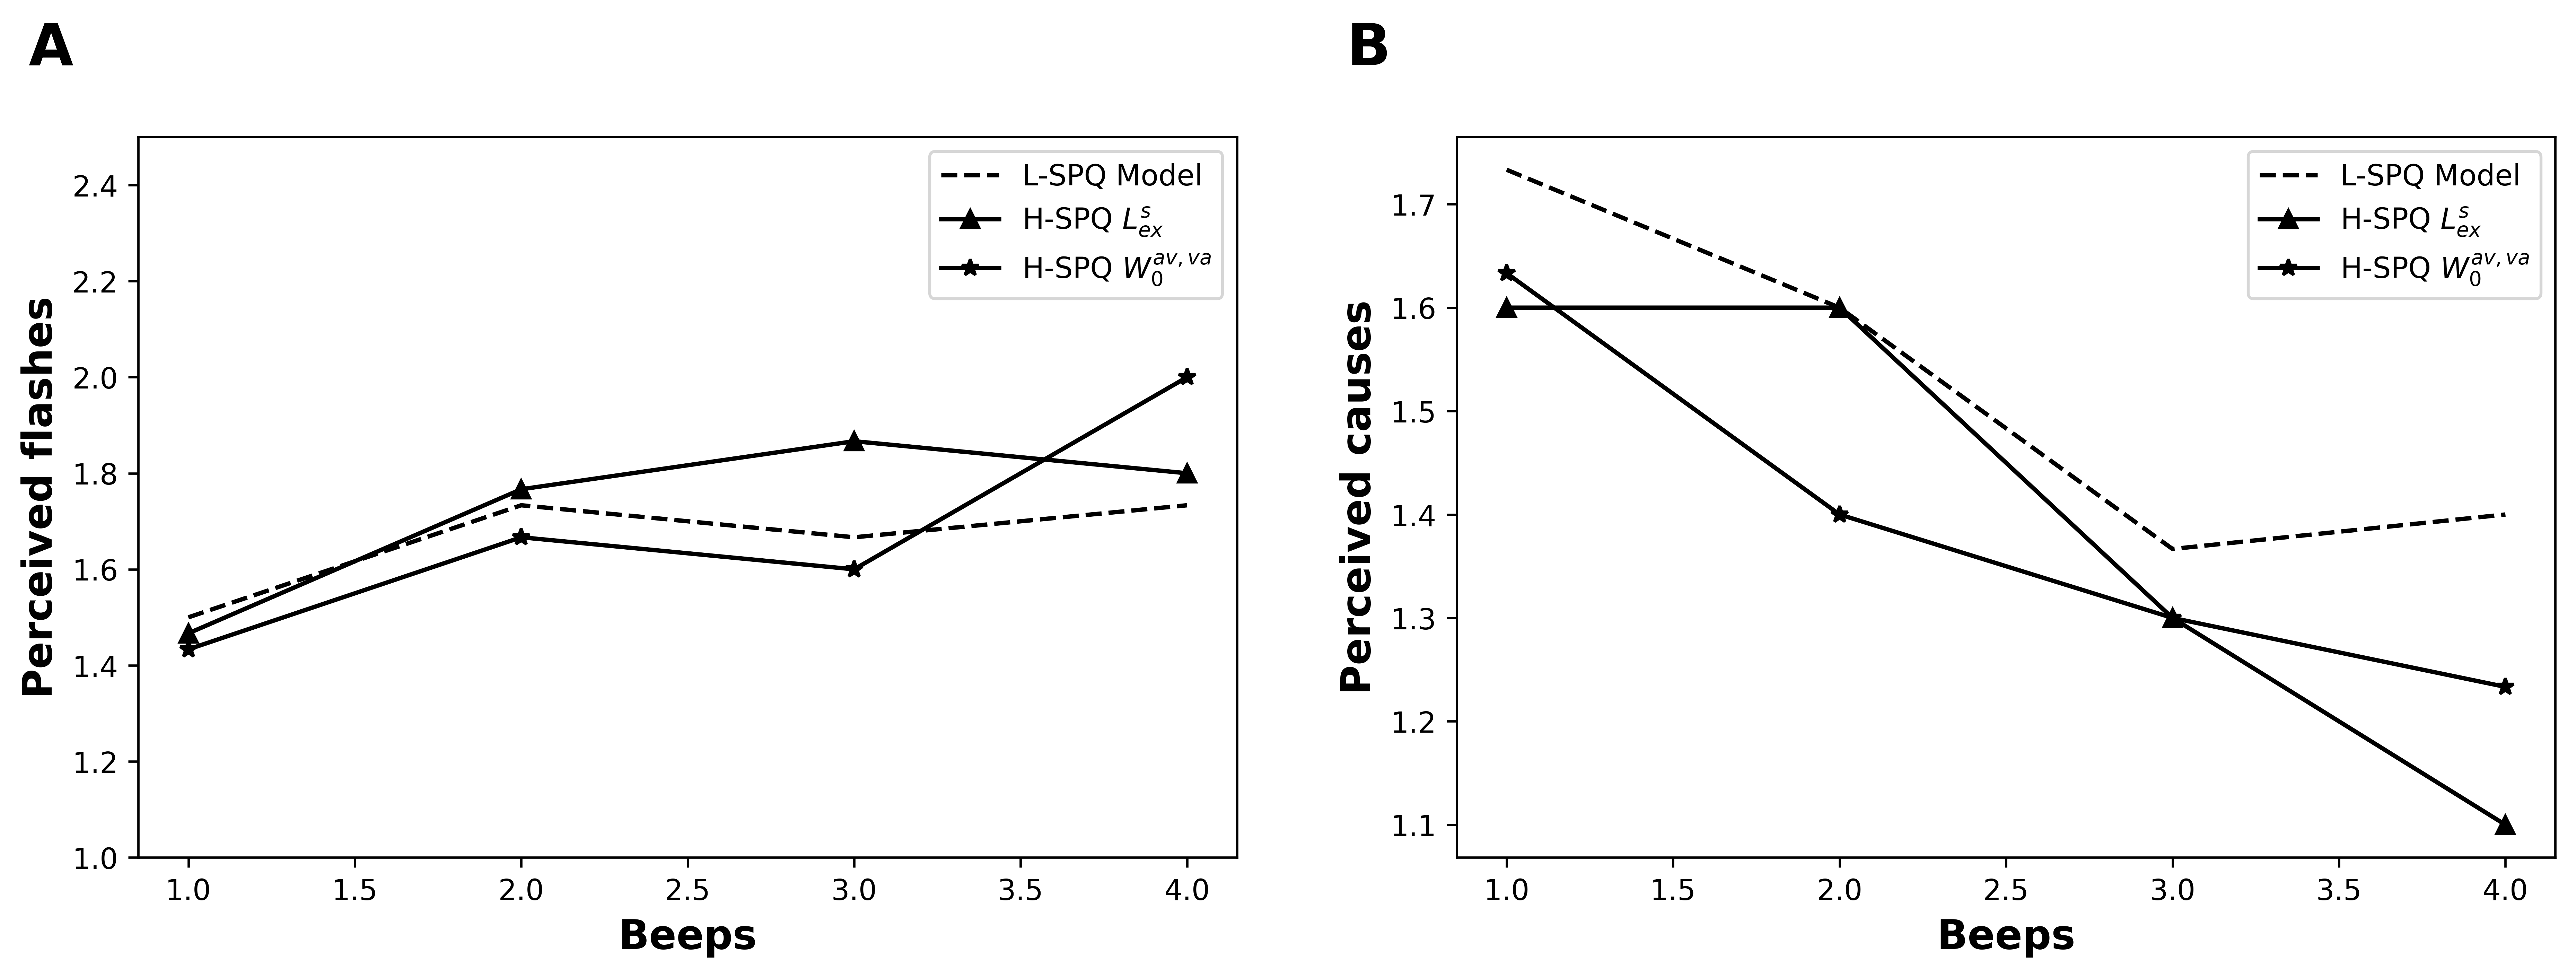

In [49]:
import matplotlib.pyplot as plt
import string

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=600)

ax1 = plt.subplot(121)
ax1.plot(beeps_range, flashes_per_beep, "--", label="L-SPQ Model", color="k")
ax1.plot(
    beeps_range,
    flashes_per_beep_hspq,
    label="H-SPQ " + r"$L_{ex}^{s}$",
    color="k",
    marker="^",
)
ax1.plot(
    beeps_range,
    flashes_per_beep_hspq_alter,
    label="H-SPQ " + r"$W_{0}^{av, va}$",
    color="k",
    marker="*",
)
ax1.set_ylabel("Perceived flashes", size=14, weight="bold")
ax1.set_xlabel("Beeps", size=14, weight="bold")
ax1.set_ylim(1, 2.5)
ax1.legend()
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
ax2.plot(beeps_range, causes_per_beep, "--", label="L-SPQ Model", color="k")
ax2.plot(
    beeps_range,
    causes_per_beep_hspq,
    label="H-SPQ " + r"$L_{ex}^{s}$",
    color="k",
    marker="^",
)
ax2.plot(
    beeps_range,
    causes_per_beep_hspq_alter,
    label="H-SPQ " + r"$W_{0}^{av, va}$",
    color="k",
    marker="*",
)
ax2.set_ylabel("Perceived causes", size=14, weight="bold")
ax2.set_xlabel("Beeps", size=14, weight="bold")
ax2.legend()

ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

fig.savefig("drafts/FIG5.eps", bbox_inches="tight", format="eps")